In [21]:
from virusPropagationModel import ModeledPopulatedWorld,Simulation
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
 

In [17]:
modeledWorld1 = ModeledPopulatedWorld(100,400,5)

In [18]:
simulation1 = Simulation(modeledWorld1,100)


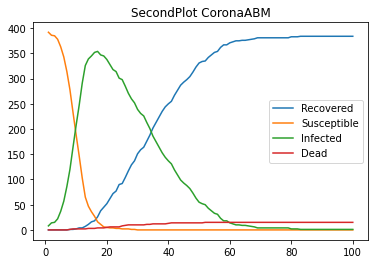

In [19]:
simulation1.plot_status_timecourse()


In [20]:
simulation1.plot_flags_timecourse()


AttributeError: 'Simulation' object has no attribute 'plot_flags_timecourse'

In [ ]:
simulation1.plot_location_type_occupancy_timecourse()

In [ ]:
simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.
